## script to load dataset for the first mouse without daily paired spontaneous imaging sessions

In [141]:
# script to convert the uploaded dataset into request format for training

In [1]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import copy
import random

Loaded 8 sessions   total laps = 248
DestinODE‑ready  x: torch.Size([8, 33, 3701, 305])  v: torch.Size([8, 33, 3701])  u: torch.Size([8, 33, 3701])


/var/folders/zl/dq7c13p16bsb4qhmx8fvgp2m0000gn/T/ipykernel_39082/3539812721.py:65: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  plt.xlabel("K"); plt.ylabel("# laps"); plt.tight_layout(); plt.show()


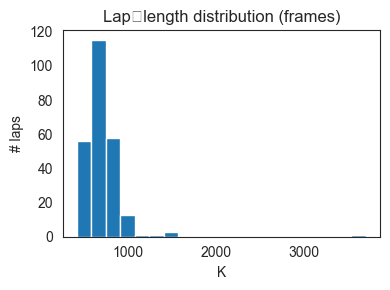

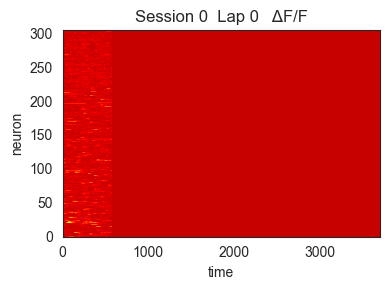

In [4]:
# ============================================================
#  Load destin_debug_subset.npz  →  x_real, v_real, u_real
#  Shapes:  [T, S, K, N], [T, S, K], [T, S, K]
# ============================================================
import numpy as np, torch, matplotlib.pyplot as plt
SUBSET_FILE = "destin_debug_subset.npz"

data = np.load(SUBSET_FILE, allow_pickle=True)
sess_ids = sorted({int(k.split('_')[1]) for k in data if k.startswith('dff_')})

# -------- build per‑session lap lists --------
x_sess, v_sess, u_sess, lap_lens = [], [], [], []
for t in sess_ids:
    dff = data[f'dff_{t}']          # [N, K_vr]
    pos = data[f'pos_{t}']
    vel = data[f'vel_{t}']
    lap_idx = data[f'lap_idx_{t}']

    laps_x, laps_v, laps_u = [], [], []
    for s in range(lap_idx.max()+1):
        m = lap_idx == s
        if not m.any():            # empty lap index
            continue
        laps_x.append(dff[:, m].T) # K_s × N   (time‑major)
        laps_v.append(vel[m])
        laps_u.append(pos[m])
        lap_lens.append(m.sum())

    x_sess.append(laps_x)
    v_sess.append(laps_v)
    u_sess.append(laps_u)

print(f"Loaded {len(sess_ids)} sessions   total laps = {sum(len(l) for l in x_sess)}")

# -------- pad laps to common K, sessions to common S --------
K_global = max(max(l.shape[0] for l in sess) for sess in x_sess)
S_max    = max(len(sess) for sess in x_sess)
N        = x_sess[0][0].shape[1]

def pad_mat(mat, K):  # for ΔF/F   [K,N]
    return np.pad(mat, ((0, K-mat.shape[0]), (0,0)))

def pad_vec(vec, K):  # for pos / vel
    return np.pad(vec, (0, K-vec.shape[0]))

def pad_session(arr_list, S, K, is_matrix):
    pad_unit = np.zeros((K, N)) if is_matrix else np.zeros(K)
    arr_list = [*arr_list, *([pad_unit]*(S-len(arr_list)))]
    arr_list = [pad_mat(a,K) if is_matrix else pad_vec(a,K) for a in arr_list]
    return np.stack(arr_list)      # [S, K, N]  or  [S, K]

x_full = np.stack([pad_session(l,S_max,K_global,True)  for l in x_sess])  # [T,S,K,N]
v_full = np.stack([pad_session(l,S_max,K_global,False) for l in v_sess]) # [T,S,K]
u_full = np.stack([pad_session(l,S_max,K_global,False) for l in u_sess]) # [T,S,K]

x_real = torch.tensor(x_full, dtype=torch.float32)
v_real = torch.tensor(v_full, dtype=torch.float32)
u_real = torch.tensor(u_full, dtype=torch.float32)

print("DestinODE‑ready  x:", x_real.shape, " v:", v_real.shape, " u:", u_real.shape)

# -------- quick sanity plots --------
plt.figure(figsize=(4,3))
plt.hist(lap_lens, bins=20); plt.title("Lap‑length distribution (frames)")
plt.xlabel("K"); plt.ylabel("# laps"); plt.tight_layout(); plt.show()

plt.figure(figsize=(4,3))
plt.imshow(x_real[0,0].T, aspect='auto', origin='lower', cmap='hot')
plt.title("Session 0  Lap 0   ΔF/F"); plt.xlabel("time"); plt.ylabel("neuron")
plt.tight_layout(); plt.show()
